In [ ]:
# Environment specified in environment.yml (environment name map_matching_particle_filter)
# conda env create --prefix ./envs -f environment.yml

In [ ]:
# TODO: Why do I need to re-run the cell that defines the particle filter in order to 
# get an empty object, with no Viterbi Trellis information?

In [1]:
import pandas as pd #'0.24.2'
import numpy as np # '1.16.4'
import os, sys
import glob, re, time

import shapely  #'1.6.4.post1'
from shapely.strtree import STRtree
from shapely.geometry import shape, Point, LineString, MultiLineString
from shapely.ops import nearest_points
import folium
import fiona
import pyproj
from functools import partial
import math

from collections import Counter

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from sklearn.metrics.pairwise import haversine_distances  # Assumes (lat, long) in radians; version 0.22.1

In [2]:
os.environ['PROJ_LIB']

'/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/share/proj'

In [21]:
# os.environ['PROJ_LIB'] = \
# "/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/lib/python3.7/site-packages/fiona/proj_data/"
# os.environ['PROJ_LIB'] = "/Volumes/LaCie/anaconda/share/proj"

In [3]:
os.getcwd()

'/Volumes/LaCie/Documents/repos/particle_filter'

In [ ]:
"""
Applications of particle filters: 
1. Car positioning by map matching, as in http://www.diva-portal.org/smash/get/diva2:316556/FULLTEXT01.pdf
    Essentially same approach is described in Davidson, Collin, and Takala (2011). Application of particle filters to map-matching algorithm
    Idea also similar to Newson and Krumm (2009), though HMM is used there.
    More recent resource: Murphy, Pao, Yuen (2019). Lyft; Map matching when the map is wrong: Efficient on/off road vehicle tracking and map learning

Ideas
Rao-Blackwellization (use Kalman filter for the linear part of the dynamics model)

Initial Approach:
Use Newson and Krumm, but modify it to use particle filters instead of HMM.

So, for a given route, proceed sequentially over obs, maintaining dist of probable road segments

Assumptions (N&K):
-remove obs that are not 2*meas dist sigma from previous obs  (eliminate 39% of data in N&K)
-ignore roads 200m from obs
-zeroize very unlikely particles
"""

In [4]:
def great_circle_dist(df):
    """
    USED BELOW IN PREPROCESSING
    df numpy array [lat, long, lat_prev, long_prev] in degrees
    
    Returns great-circle distance between point (lat,long) columns and (lat_prev, long_prev) columns, 
    in meters.
    
    Modified from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    df = df.copy()
    df = np.deg2rad(df)

    # haversine formula 
    dlon = df[:, 3] - df[:, 1] # lon2 - lon1 
    dlat = df[:, 2] - df[:, 0] # lat2 - lat1 
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(df[:, 0]), 
                           np.multiply(np.cos(df[:, 2]), np.square(np.sin(dlon / 2)))
                          )
              )
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = np.arcsin(np.sqrt(a)) * 2
    # c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return r * c * 1000

In [5]:
class gps_transition_model:
    """
    Transition model to predict probability of next state given current state; simulate next state.
    GPS trace map matching use case. 
    
    N&K use as a proxy an exponential function of the difference in the great-circle distance 
    between previous observations and previous road points (similar route distance).
    Road points use map/ground-truth data. 
    -Ignore roads 200m from obs
    -If a calculated route would require the vehicle to exceed a speed of 50 m/s (112 miles per hour), zeroize
    
    !!! TODO: Get driving distance from route planner??? Results anticipated to significantly suffer otherwise. !!! 
    
    Other ideas: using dead reckoning.
    """
    def __init__(self, beta=3.0
#                  , prob_floor=0.05
                 , normalize=True
                ):
        """
        beta, float, parametrizes transition probability function
        prob_floor, float between 0 and 1, is probability below which road choices are given zero probability
        
        # beta = 3 in mapzen, https://www.mapzen.com/blog/data-driven-map-matching/
        """
        self.beta = beta
#         self.prob_floor = min(max(prob_floor, 0), 1)
        self.normalize = normalize
    
    def estimate_beta(self, data):
        """
        NOT USED
        
        Using rescaled median absolute deviation (MAD). 
        Ideally using ground truth data (none here).
        """ 
        self.beta = 3.0  # None
        
    def prob_transition(self, state_last2, obs_last2, dist_obs_m_prev, time_delta_sec_prev, 
                        max_allowable_diff_m=2000.0, max_allowable_mph=112.0):
        """
        state_last2, float numpy array, (n * c x 4 lat, long, lat_prev, long_prev), c candidate roads and n particles
        obs_last2, float numpy array, (1 x 4 lat, long, lat_prev, long_prev) 
        dist_obs_m_prev float distance in meters between last two obs.
        time_delta_sec_prev float time delta in sec between last two obs.
        max_allowable_diff_m float, ignore low probability routes as in N&K; in N&K 2000 meters.
        max_allowable_mph, float; ignore routes resulting in unreasonable speeds. 112mph in N&K.
        Where present, lat/long in degrees.
        
        returns probs of transition, (n * c x 1)
        """
        RADIUS_OF_EARTH_M = 6371000
        MILES_PER_METER = 0.000621371
        HOURS_PER_SECOND = 3600.0
        state_last2 = np.deg2rad(state_last2)
        obs_last2 = np.deg2rad(obs_last2)
        # dist_obs = abs(haversine_distances(obs_last2[:, :2], obs_last2[0, 2:]))  # (1, 1)
        # !! TODO - Supposed to be driving distance, not haversine. N&K use a route planner. Can I use shapely???
            # Probably fine as generally GPS measurements are taken close together in time- 
            # Otherwise would have to snap to roads using Shapely and get the distance between the two points. 
            # How does using driving distance even compare to haversine for obs? Isn't it better to compare apples to apples?
        dist_road = \
        np.abs(np.array([haversine_distances(state_last2[r, :2].reshape(1,2), state_last2[r, 2:].reshape(1,2))[0] 
                         for r in range(state_last2.shape[0])]))  # (n * c, 1)
        dist_road = dist_road * RADIUS_OF_EARTH_M  # multiply by Earth radius to get result in meters
        diff_dist = np.abs(np.subtract(dist_road, dist_obs_m_prev))  # (n * c, 1)
        
        # Ignore cases where diff_dist >= max_allowable_diff_m
        diff_dist[diff_dist >= max_allowable_diff_m] = np.float("inf")  # zero out these transition probs
        # Ignore cases where implied speed of route is >= max_allowable_mph; calculate speed in candidate routes
        implied_speed_road = np.divide(dist_road * MILES_PER_METER, 
                               time_delta_sec_prev * HOURS_PER_SECOND)  # (n * c, 1), meters
        diff_dist[implied_speed_road >= max_allowable_mph] = np.float("inf")  # zero out these transition probs
        
        probs = np.exp(-diff_dist / self.beta) * (1 / self.beta)
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs

In [6]:
class gps_sensor_model:
    """
    Sensor model to predict likelihood of an obs given a particle.
    GPS trace map matching use case. 
    
    I don't have ground truth, so can't use ML easily, but
    N&K use as a proxy a normal distribution of great-circle distance between observation and road, with sigma 
    estimated from the data.
    Road points use map data. 
    -Zerioze low probability particles (diff in route distance of 2000 m. or more). 
    
    Other ideas: semi-supervised learning. 
    
    Thoughts: need efficient representation for road network that returns connecting roads/nodes for a given node
    Want to represent it as a graph/network. 
    """
    def __init__(self, sigma=4.07, normalize=True):
        self.sigma = sigma
        self.normalize = normalize
    
    def estimate_sigma(self, data):
        """
        NOT USED 
        
        Using Gather and Schultze, median-based. 
        Ideally using ground truth data (none here).
        
        I guess I could manually match some trips, then use that??
        """ 
        self.sigma = 4.07 # meters; I have no ground truth so using N&K's empirical estimate
#         self.sigma = None # median absolute deviation (MAD) formula adjusted 
    
    def estimate_likelihood(self, states, obs_coords):
        """
        return probability of seeing that obs given potential road state hypotheses, (k x 1)
        
        states Particles numpy array representing road position hypotheses, (k x 2 lat long).
        obs_coords (1 x 2 lat long)
        lat long in degrees
        """
        RADIUS_OF_EARTH_M = 6371000
        dist_obs_roads = np.abs(haversine_distances(np.deg2rad(states), np.deg2rad(obs_coords)))  # (k x 1)
        dist_obs_roads = dist_obs_roads * RADIUS_OF_EARTH_M  # multiply by Earth radius to get result in meters
        
        probs = \
        np.exp(np.power(dist_obs_roads / self.sigma, 2) * (-0.5)) * \
        (1 / (math.sqrt(2 * math.pi) * self.sigma))
        
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs

In [489]:
class particle_filter:
    """
    Fit a particle filter to data given a transition and sensor model. 
    
    n, integer, number of particles to maintain at each step in time.
    max_road_dist_m, float, max road distance above which candidate roads aren't considered (meters). 
    prob_floor, float between 0 and 1, min probability below which candidate roads aren't considered (not in N&K).
    Sensor model, , is some model object we will use to predict the likelihood.
    Transition model, , is some model object we will use to predict next state.
    ## max_iter, integer, the maximum iterations used in fitting the particle filter.
    ## conv_tol, the convergence tolerance that will trigger early termination of fitting the particle filter. 
    """
    def __init__(self, road_strtree, n=50, max_road_dist_m=200, prob_floor=0.0, 
                 sensor_model=gps_sensor_model(), transition_model=gps_transition_model(), 
                 viterbi_trellis=[], viterbi_trellis_idx=[]):
        self.road_strtree = road_strtree
        self.n = n
        self.max_road_dist_m = max_road_dist_m
        self.prob_floor = min(max(prob_floor, 0), 1)
        self.particles = np.array([])
        self.weights = np.zeros((1, self.n))  # Log-transform probabilities
        
        self.sensor_model = sensor_model
        self.transition_model = transition_model
        self.viterbi_trellis = viterbi_trellis  # list of particle np arrays
        self.viterbi_trellis_idx = viterbi_trellis_idx  # list of np arrays, columns candidate road indices, particle indices
        
        self.fitted = False
        
        self.obs_history = []  # Record history of observations (lat, long)
        
    def get_candidate_roads(self, obs):
        """
        obs list of floats [lat, long]
        max_dist maximum allowable closest distance for prospective matched roads; those whose 
        closest point is >= max_dist meters away are ignored (200 in N&K).
        Returns numpy array float of lat,long closest point to road from obs (N&K).

        Leverages shapely and shapefiles for cabspotting data.
        Relies on great_circle_dist() helper function. 
        """
        # Fiona uses (long, lat) format
        obs = Point(obs[::-1])
        # Want to consider only matches within max_dist meters
        # Need to transform decimal degrees into meters
        # Should I deviate from the default value of buffer for a Point??
        # According to 200 * 360 / (2 * np.pi * 6371000), a distance of 200m corresponds to 0.0017986432118374611 decimal degrees
        # obs.buffer(1.0)
        matching_roads = self.road_strtree.query(obs.buffer(0.002))
        if len(matching_roads) == 0:
            matching_roads = self.road_strtree.query(obs.buffer(1.0))  # This should be a big buffer
        # If matching roads is still empty, return None
        if len(matching_roads) == 0:
            print("No matching roads found! Aborting particle filter.")
            return None
        # Ordered as (obs, road); just take road's coords
        # Take only the closest point on the candidate road (1st index)
        closest_pts = np.array([[list(p.coords)[0] for p in nearest_points(obs, r)][1] for r in matching_roads])
        # Calculate distance between obs and candidate_roads, to filter them
        candidate_dist_coords = \
        np.concatenate([closest_pts, np.tile(np.array(obs), (closest_pts.shape[0], 1))], axis=1)
        # Convert back to lat, long from long, lat
        candidate_dist_coords = candidate_dist_coords[:, [1, 0, 3, 2]]
        candidate_dists = great_circle_dist(candidate_dist_coords)
        # Filtered result of closest point on matching candidate roads
        # no. matches 2 (default buffer); 52 (buffer of 0.002); 74 (buffer of 1.0)
            # Reverse order to be lat, long
        candidate_roads = closest_pts[candidate_dists <= self.max_road_dist_m][:, [1,0]]
        if len(candidate_roads) == 0:
            print("No matching roads found within max road distance! Aborting particle filter.")
            return None
        return candidate_roads
    
    def estimate_weights_per_particle(self, sampled_states, obs_coords):
        """
        Estimate likelihood of particle given evidence, P(evidence|particle).
        Uses sensor model.
        
        obs_coords is single observation at time t, pandas series. 
        """
        probs = self.sensor_model.estimate_likelihood(sampled_states, obs_coords.values.reshape(1, 2))
        return probs
        
    def apply_transition_model(self, candidate_roads, dist_prev, time_delta_prev):
        """
        returns probabilities of transition, given current particles
        numpy array of floats between 0 and 1, normalized, (n * c, 1)
        
        candidate_roads numpy array float of lat,long closest point to road from obs (N&K)
        dist_prev float, meters
        time_delta_prev float, sec
        
        Zeroize very small probability candidates, but don't change shape of particles.
        Then, if some particles are very unlikely, we cull them and resample from more likely particles. 
        """
        # Crossproduct for each particle, all roads
        state_last2 = np.concatenate([np.concatenate((self.particles, 
                                                      np.tile(c, (self.n, 1))), 
                                                     axis=1) 
                                      for c in candidate_roads], axis=0)  # (n * c, 4)
        obs_last2 = np.array(self.obs_history[-2:]).reshape((1, 4))
        probs = self.transition_model.prob_transition(state_last2, obs_last2, 
                                                      dist_prev, time_delta_prev)  # (n * c, 1)
        # Effectively, candidate roads will be possible from different original particle hypotheses
        # Zeroise small probs, without changing array shape
        probs[probs <= self.prob_floor] = 0.0
        # Re-normalize
        probs = probs / np.sum(probs)
        return probs
        
    def update_dist(self, obs, num_iter, max_dist2=None):
        """
        Re-sample particles from transition model given re-estimated likelihood of existing particles.
        Weighted sample with replacement. 
        
        obs numpy array of floats [lat, long, dist_from_prev_m, time_delta_sec]
        num_iter integer, iteration count
        max_dist2 not used

        Note: if find no solutions, need to remove points in a signal break until HMM 'heals.'
        If break > 180 sec, separate into two trips.
        """
        # Update stored obs
        obs_coords = obs[['lat', 'long']] # obs[:2]
        dist_prev, time_delta_prev = obs[['dist_from_prev_m', 'time_delta_sec']] # obs[2:]
        self.obs_history.append(obs_coords)
        # Get candidate roads given obs
        candidate_roads = self.get_candidate_roads(obs_coords) # ignore distance
        # What if candidate_roads is empty?? Then, seems logical to return No Match, and abort. 
        if candidate_roads is None:
            return 'Aborted'
        # Get transition probs; for first observation, ignore this part of the algorithm 
        # and treat sensor probs as prior probabilities (N&K.
        if num_iter > 1:
            trans_probs = self.apply_transition_model(candidate_roads, 
                                                      dist_prev, 
                                                      time_delta_prev) # (n * c, 1) first n rows for first candidate, etc.
            # Aggregate probs by candidate roads
            trans_probs_split = np.array(np.split(trans_probs, self.n, axis=0))  # (n, c, 1)
            trans_probs_agg = np.sum(trans_probs_split, axis=0)  # (c, 1)
            # Sample new states
            # Sample new states; index into candidate roads
            sampled_states_idx = np.random.choice(range(len(candidate_roads)), 
                                                  self.n, 
                                                  list(trans_probs_agg.flatten()))  # (n, )
            sampled_states = candidate_roads[sampled_states_idx]  # (n, 2)
            sampled_states_best_prior = np.argmax(trans_probs_split[:, sampled_states_idx, :], axis=0)  # (n, 1)
        else:
            sampled_states = candidate_roads
            sampled_states_best_prior = np.zeros((self.n, 1))  # dummy value
        
        # Get sensor probs
        sensor_probs = self.estimate_weights_per_particle(sampled_states, obs_coords)  # (n, 1) 
        
        # Joint prob, for viterbi backtracking. Do this in the log domain.  
        if num_iter > 1:
            # May want to do this in the log domain?
            joint_prob = np.add(
                np.add(np.log(sensor_probs), np.max(np.log(trans_probs_split), axis=0)[sampled_states_idx]),  # (n, 1)
                self.weights
                )
        
        # Sample new particles, from the n sampled states
        new_particles_idx = np.random.choice(a=range(sampled_states.shape[0]), 
                                             size=self.n, 
                                             p=sensor_probs.flatten())  # (1, n) if not iter 1 else (1, c)
        new_particles = sampled_states[new_particles_idx]  # (n, 2)
        
        # Best prior state/particle for a given candidate state, for viterbi backtracking. 
        if num_iter > 1:
            self.viterbi_trellis.append(new_particles)
            self.viterbi_trellis_idx.append(sampled_states_best_prior)
        else:
            self.viterbi_trellis.append(new_particles)
            self.viterbi_trellis_idx.append(sampled_states_best_prior)
            joint_prob = np.log(sensor_probs[new_particles_idx])  # Effectively setting prior probabilites in iter 1
            
        self.weights = joint_prob
        
        self.particles = new_particles
        
        # Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
            # Came up with this on my own. 
        fit_quality = [np.max(self.weights), np.mean(self.weights), np.median(self.weights)]
        
        return fit_quality
        
    def fit(self, data#, max_iter=100, conv_tol=0.001
           ):
        """
        Iterate over rows in data, training particle filter. 
        Rows assumed to be sequentially ordered. 
        
        data, numpy array: cols include lat, long, dist_from_prev_m, time_delta_sec (all floats).
        lat, long in decimal degrees.
        
        Returns fit_quality, list of floats: max, mean, and median probability of most recent particles.
        
        Note, calling fit multiple times would result in nonsense results, so this is prevented. 
        """
        if self.fitted:
            print("Already fit - Cannot fit multiple times.")
            return None
        data = data.copy()
        num_iter = 0
        converged = False  # Is this relevant for particle filters?
#         while num_iter < max_iter and not converged:
#             num_iter += 1
        for obs in data.iterrows():
            num_iter += 1
            fit_quality = self.update_dist(obs[1], num_iter)
            if fit_quality == "Aborted":
                return "Aborted"
            # Shouldn't I use DP/Viterbi for this?? 
            # Nearest neighbor filter, hungarian algorithm?? p. 601
            # Best at any given point in time will suffer in the beginning before particle dist has converged, ie
            # during the burn-in period.
            # So, seems can still use DP, but proceed backward in time. Wait, that is Viterbi :) 
                # Happily I have a finite state space. 
            print("On iteration %d, fit quality of MAX %3.2f, MEAN %3.2f, MEDIAN %3.2f" % 
                  (num_iter, fit_quality[0], fit_quality[1], fit_quality[2]))
        print("Done.")
        self.fitted = True
        return fit_quality
    
    def viterbi(self):
        """
        Returns list of backtracked states (float lat long),
        the imputed GPS trace that has been 'snapped' to roads.
        Use Viterbi to get optimal path via DP - 
        happily I have a finite state space due to my constraint 
        to only maintain n particles. 
        
        Note1, Viterbi relies on the Markov property, which
        can apply here. 
        Note2, if particle filter was aborted due to no matching candidate roads,
        Viterbi will still be able to backtrack the trace up until that point. 
        """
        # Start with the last observation to the viterbi trellis
        best_last_state_idx = np.argmax(self.weights)
        backtracked_states = []
        # Backtrack through the viterbi trellis (#obs, n, 2) actual lat/long states
        for j in range(len(self.viterbi_trellis) - 1, -1, -1):
            # for that 'candidate road,' the particle index (col 1)
            best_last_state = self.viterbi_trellis[j][best_last_state_idx]
            best_last_state_idx = int(self.viterbi_trellis_idx[j][best_last_state_idx])
            backtracked_states.append(best_last_state)
        # Put in chronological order
        backtracked_states = backtracked_states[::-1]
        return backtracked_states

In [ ]:
## READ IN DATA ##

In [8]:
## it seems i only have beijing data (10K) or sf taxi data (500)
# Read in taxi data
# Each data of different length; ideal use case for pyspark
# Note, the OSM extract basemap data has POI info as well (https://download.bbbike.org)
# also try uber h3 spatial index
trace_dir = '/Volumes/LaCie/datasets/ms_taxi/taxi_log_2008_by_id/roads.shp'   # MS Taxi
basemap_dir = '/Volumes/LaCie/datasets/Beijing-shp/shape/'

trace_dir = '/Volumes/LaCie/datasets/cabspottingdata/'   # CRAWDAD cabspotting
basemap_dir = '/Volumes/LaCie/datasets/SanFrancisco-shp/shape/roads.shp'

In [9]:
%%time
all_files = [f for f in os.listdir(trace_dir) if re.match(r'new_.*\.txt', f)]  # glob.glob(trace_dir + "new_*.txt")

CPU times: user 2.45 ms, sys: 4.22 ms, total: 6.67 ms
Wall time: 69.2 ms


In [268]:
# %%time
# # 20.9s cabspottingdata; can try spark or dask? or multiprocessing, joblib
# trace_list = []
# for file_ in all_files:
#     file_df = pd.read_csv(os.path.join(trace_dir, file_), sep=" ", index_col=None, header=None, 
#                           names=['lat', 'long', 'occupancy', 'time'])
#     trace_list.append(file_df)

# # concatenate all dfs into one
# trace_df = pd.concat(trace_list, ignore_index=True)

In [314]:
all_files_idx = 1
all_files[all_files_idx]

'new_abcoij.txt'

In [235]:
# Just try one trace...
trace_df = pd.read_csv(os.path.join(trace_dir, all_files[all_files_idx]), sep=" ", index_col=None, header=None, 
                       names=['lat', 'long', 'occupancy', 'time'])

In [236]:
trace_df.loc[:, ["time"]] = pd.to_datetime(trace_df.time, origin="unix", unit='s')

In [237]:
# Order by time
trace_df = trace_df.sort_values(by="time").reset_index(drop=True)

In [238]:
"""
cabspotting:

latitude and longitude are in decimal degrees, 
occupancy shows if a cab has a fare (1 = occupied, 0 = free) and 
time is in UNIX epoch format
"""
trace_df.dtypes

lat                 float64
long                float64
occupancy             int64
time         datetime64[ns]
dtype: object

In [239]:
trace_df.head()

,lat,long,occupancy,time
0,37.80346,-122.41466,1,2008-05-17 23:11:30
1,37.80519,-122.41773,1,2008-05-17 23:12:30
2,37.80491,-122.41971,1,2008-05-17 23:13:30
3,37.80470,-122.42117,1,2008-05-17 23:14:30
4,37.80448,-122.42295,1,2008-05-17 23:15:31


In [14]:
def preprocess_traces(df, sigma=4.07):
    """
    pandas df, trace_df above with float columns lat, long in degrees
    sigma float, representing std dev of measurement error (see above in particle filter class)
    
    "The justification for this step is that until we see a point that is at least 2𝜎𝑧 
    away from its temporal predecessor, our confidence is low that the apparent movement
    is due to actual vehicle movement and not noise." (N&K)
    
    -remove obs that are not 2*meas dist sigma from previous obs  (eliminate 39% of data in N&K)
    -Letting sigma = 4.07 meters as in N&K
    """
    MILES_PER_METER = 0.000621371
    HOURS_PER_SECOND = 3600.0
    data = df.copy()
    data[["lat_prev", "long_prev"]] = data[["lat", "long"]].shift(1)
    # Ignore warning about invalid value in arcsin (nan)
    data["dist_from_prev_m"] = great_circle_dist(data[["lat_prev", "long_prev", "lat", "long"]].values)  # 1.93 sec
    # Add speed so can later filter on unreasonably high speeds
    data["time_delta_sec"] = data.time.subtract(data.time.shift(1)) / np.timedelta64(1, 's')  # get seconds
    data["speed_mph"] = (data.dist_from_prev_m * MILES_PER_METER).divide(data.time_delta_sec * HOURS_PER_SECOND)
    # Take cumsum of dist
    dist_cum = data.dist_from_prev_m.cumsum()
    # Select points closest to multiples of 2*sigma, in cumsum dist
    dist_cum_idx = dist_cum // (2 * sigma)
    filter_idx = np.subtract(dist_cum_idx, dist_cum_idx.shift(1)) == 0  # 12% of rows eliminated 
    data = data[~filter_idx]
    return data

In [240]:
%%time
# 11.8 s
# Ignore RuntimeWarning: invalid value encountered in arcsin
trace_df = preprocess_traces(trace_df)

CPU times: user 13.9 ms, sys: 2.91 ms, total: 16.8 ms
Wall time: 17.4 ms


In [241]:
trace_df.head()

,lat,long,occupancy,time,lat_prev,long_prev,dist_from_prev_m,time_delta_sec,speed_mph
0,37.80346,-122.41466,1,2008-05-17 23:11:30,NaN,NaN,NaN,NaN,NaN
1,37.80519,-122.41773,1,2008-05-17 23:12:30,37.80346,-122.41466,331.289969,60.0,9.530277e-07
2,37.80491,-122.41971,1,2008-05-17 23:13:30,37.80519,-122.41773,176.717645,60.0,5.083668e-07
3,37.80470,-122.42117,1,2008-05-17 23:14:30,37.80491,-122.41971,130.377203,60.0,3.750584e-07
4,37.80448,-122.42295,1,2008-05-17 23:15:31,37.80470,-122.42117,158.285057,61.0,4.478768e-07


In [ ]:
"""
Trace_df needs to be pre-processed to separate out actual trips.
It is a concatenation of multiple days' worth of trips for a single cab. 

Below I use the distribution of successive time differences between consecutive measurements 
to split trips; instead I could isolate stretches of the trace where occupancy=1. 
"""

In [242]:
trace_time_diff = \
np.abs(np.subtract(trace_df.time, trace_df.time.shift(1)) / np.timedelta64(1, 's')).fillna(0).values

In [243]:
np.histogram(trace_time_diff)

(array([2495,    0,    2,    2,    0,    1,    1,    2,    0,    2]),
 array([     0. ,  18571.2,  37142.4,  55713.6,  74284.8,  92856. ,
        111427.2, 129998.4, 148569.6, 167140.8, 185712. ]))

In [244]:
np.histogram(trace_time_diff[trace_time_diff < 10000])

(array([2486,    2,    0,    1,    2,    1,    1,    0,    0,    1]),
 array([   0. ,  968.3, 1936.6, 2904.9, 3873.2, 4841.5, 5809.8, 6778.1,
        7746.4, 8714.7, 9683. ]))

In [245]:
np.histogram(trace_time_diff[trace_time_diff < 1000])

(array([1227,  519,  503,  105,   73,   38,   11,    9,    0,    1]),
 array([  0. ,  84.4, 168.8, 253.2, 337.6, 422. , 506.4, 590.8, 675.2,
        759.6, 844. ]))

In [246]:
trip_secdiff_thesh_s = 10 * 60

In [247]:
trip_starts = trace_df.index[trace_time_diff > trip_secdiff_thesh_s]  # I guess I could just call these trips

In [248]:
trip_starts.shape

(26,)

In [249]:
trip_starts

Int64Index([  73,  177,  192,  426,  491, 1218, 1441, 2161, 2249, 2371, 2581,
            2605, 2723, 2806, 3650, 3873, 4323, 4425, 4449, 4503, 4569, 4754,
            4836, 5376, 5407, 5449],
           dtype='int64')

In [250]:
trips_list = []
i_prev = 0
for i in trip_starts:
    trips_list.append(trace_df.loc[i_prev:i-1, :])
    i_prev = i
trips_list.append(trace_df.loc[i_prev:, :])

In [267]:
trips_list[0].shape

(61, 9)

In [252]:
sum([d.shape[0] for d in trips_list]) == trace_df.shape[0]

True

In [ ]:
# Read in roads shapefiles

In [334]:
%%time
roads_shp = fiona.open(basemap_dir)

CPU times: user 2.03 ms, sys: 5.03 ms, total: 7.05 ms
Wall time: 358 ms


In [18]:
roads_shp.crs

{'init': 'epsg:4326'}

In [ ]:
## https://gis.stackexchange.com/questions/80881/what-is-unit-of-shapely-length-attribute
# line1 = LineString([(15.799406, 40.636069), (15.810173,40.640246)])
# print str(line1.length) + " degrees"
# # 0.0115488362184 degrees

# # Geometry transform function based on pyproj.transform
# project_m = partial(
#     pyproj.transform,
#     pyproj.Proj(init='EPSG:4326'),
#     pyproj.Proj(init='EPSG:32633'))

# line2 = transform(project_m, line1)
# print str(line2.length) + " meters"
# # 1021.77585965 meters

In [832]:
roads_shp.schema

{'properties': OrderedDict([('osm_id', 'int:11'),
              ('name', 'str:48'),
              ('ref', 'str:16'),
              ('type', 'str:16'),
              ('oneway', 'int:1'),
              ('bridge', 'int:1'),
              ('maxspeed', 'int:3')]),
 'geometry': 'LineString'}

In [20]:
# Types of geometries
set([r['geometry']['type'] for r in list(roads_shp)])
# sf_shp: {'LineString'}

{'LineString'}

In [21]:
roads_shp[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('osm_id', 4311275),
              ('name', 'Bayshore Freeway'),
              ('ref', 'US 101'),
              ('type', 'motorway'),
              ('oneway', 1),
              ('bridge', 0),
              ('maxspeed', 65)]),
 'geometry': {'type': 'LineString',
  'coordinates': [(-122.4067318, 37.6552091),
   (-122.4066705, 37.6554806),
   (-122.4066, 37.6557348),
   (-122.4065183, 37.6560026),
   (-122.4064254, 37.6562575),
   (-122.4063177, 37.6565034),
   (-122.4061926, 37.6567579),
   (-122.4055559, 37.6579996),
   (-122.4053176, 37.6584642),
   (-122.4051888, 37.658704),
   (-122.405056, 37.6589448),
   (-122.4049166, 37.659174),
   (-122.4047675, 37.6593902),
   (-122.4046031, 37.6596144),
   (-122.4044278, 37.6598328),
   (-122.404206, 37.660081),
   (-122.4039932, 37.6603049),
   (-122.4037717, 37.6605162),
   (-122.4035097, 37.6607433),
   (-122.4032666, 37.6609362),
   (-122.4030265, 37.6611163),
   (-122.402762, 37.

In [335]:
%%time
# Wall time: 1.79 s
# Just preserving geometries for my purpose
road_geoms = [shape(shp['geometry']) for shp in roads_shp]

CPU times: user 1.29 s, sys: 46.8 ms, total: 1.33 s
Wall time: 1.4 s


In [345]:
%%time
# Wall time: 282 ms
# Create STR-tree as input to particle filter
road_strtree = STRtree(road_geoms)

CPU times: user 254 ms, sys: 28.3 ms, total: 282 ms
Wall time: 272 ms


In [ ]:
# Instantiate Particle Filter

In [490]:
# !!! Need to re-run the cell that defines the class as well to reset it for some reason. !!!
del my_particle_filter
my_particle_filter = particle_filter(road_strtree)

In [ ]:
# Select a trip for fitting particle filter

In [477]:
trip_idx = 6
trip_df = trips_list[trip_idx]

In [499]:
trip_df.shape

(50, 9)

In [500]:
# How long was this trip?
trip_df.time.max() - trip_df.time.min()

Timedelta('0 days 00:50:06')

In [ ]:
""" 
Optionally, let's see what happens when we augment this trip to have an errant GPS point.
As see in the augmentation of the original trace, most of the time the algorithm does not correct for 
the errant GPS trace.
However, 50% of the time out of two sample runs, it did correct for a smaller errant gps trace (new_abcoij_6_aug3.png).

Actually I don't think the algorithm is explicitly designed to do this, 
unless the comparison of great-circle to driving distance in the transition step 
indirectly does this (I do not implement this part). The algorithm seems to be doing more general smoothing.

Also, maybe this would perform better if my GPS frequency was higher. 
N&K's paper uses a trace sampled at 1 Hz; the cabspotting traces are sampled at roughly 1/60 Hz.
"""

In [405]:
trip_df_aug = trip_df.iloc[:50,:].copy().reset_index(drop=True)

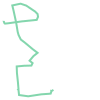

In [409]:
# Before augmentation
LineString(trip_df_aug[['long', 'lat']].values)

In [427]:
trip_df_aug.loc[23:27, :]

,lat,long,occupancy,time,lat_prev,long_prev,dist_from_prev_m,time_delta_sec,speed_mph
23,37.77303,-122.40326,0,2008-05-22 17:16:36,37.77121,-122.40556,286.047251,62.0,7.963327e-07
24,37.77522,-122.40615,0,2008-05-22 17:17:34,37.77303,-122.40326,351.881336,58.0,1.047169e-06
25,37.77742,-122.42000,0,2008-05-22 17:18:28,37.77522,-122.40615,335.957783,54.0,1.073840e-06
26,37.77915,-122.41088,0,2008-05-22 17:19:22,37.77742,-122.40877,267.196117,54.0,8.540531e-07
27,37.78059,-122.41277,1,2008-05-22 17:20:16,37.77915,-122.41088,230.713745,54.0,7.374425e-07


In [462]:
# Place an errant point in the middle of the tract
trip_df_aug.loc[25, ["lat", "long"]] = np.array([37.77742, -122.41])  # Doesn't correct it
trip_df_aug = preprocess_traces(trip_df_aug[["lat", "long", "occupancy", "time"]])
# trip_df_aug.loc[25, ["lat", "long"]] = np.array([37.77742, -122.42])  # 

In [463]:
trip_df_aug.loc[23:27, :]

,lat,long,occupancy,time,lat_prev,long_prev,dist_from_prev_m,time_delta_sec,speed_mph
23,37.77303,-122.40326,0,2008-05-22 17:16:36,37.77121,-122.40556,286.047251,62.0,7.963327e-07
24,37.77522,-122.40615,0,2008-05-22 17:17:34,37.77303,-122.40326,351.881336,58.0,1.047169e-06
25,37.77742,-122.41000,0,2008-05-22 17:18:28,37.77522,-122.40615,417.540812,54.0,1.334608e-06
26,37.77915,-122.41088,0,2008-05-22 17:19:22,37.77742,-122.41000,207.332385,54.0,6.627075e-07
27,37.78059,-122.41277,1,2008-05-22 17:20:16,37.77915,-122.41088,230.713745,54.0,7.374425e-07


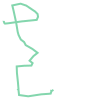

In [464]:
# After augmentation
LineString(trip_df_aug[['long', 'lat']].values)

In [488]:
trip_df = trip_df_aug

In [ ]:
"""
End optional section for augmenting GPS trace. 
"""

In [491]:
data = trip_df[['lat', 'long', 'lat_prev', 'long_prev', 'dist_from_prev_m', 'time_delta_sec']].copy()

In [482]:
data.shape

(167, 6)

In [493]:
%%time
# Run/fit the particle filter.

# first -inf results in mean and median, not max, then in all...
# Runtime warning, divide by zero in log
# Error at iter 1381; 3 min
"""
For the first cabspotting trace, new_abboip.txt, I see why my particle filter loses the trail before it ends - 
my shapefile only covers San Francisco but the person 
drives into the East Bay. Ditto for new_abcoij.txt.

Oh I see. These traces are over multiple trips and days for one cab... Need to separate them into trips first. 

I always have to reinstantiate the particle filter to get rid of info in viterbi_trellis! Not sure why.
"""
results = my_particle_filter.fit(data)

On iteration 1, fit quality of MAX -0.59, MEAN -0.69, MEDIAN -0.59
On iteration 2, fit quality of MAX -5.59, MEAN -inf, MEDIAN -694.17
On iteration 3, fit quality of MAX -30.54, MEAN -inf, MEDIAN -inf


/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/lib/python3.7/site-packages/ipykernel/__main__.py:159: RuntimeWarning: divide by zero encountered in log


On iteration 4, fit quality of MAX -362.44, MEAN -inf, MEDIAN -inf
On iteration 5, fit quality of MAX -982.34, MEAN -inf, MEDIAN -inf
On iteration 6, fit quality of MAX -1151.56, MEAN -inf, MEDIAN -inf
On iteration 7, fit quality of MAX -1218.43, MEAN -inf, MEDIAN -inf
On iteration 8, fit quality of MAX -1224.54, MEAN -inf, MEDIAN -inf
On iteration 9, fit quality of MAX -1506.28, MEAN -inf, MEDIAN -inf
On iteration 10, fit quality of MAX -2164.10, MEAN -inf, MEDIAN -inf
On iteration 11, fit quality of MAX -2362.85, MEAN -inf, MEDIAN -inf
On iteration 12, fit quality of MAX -3031.35, MEAN -inf, MEDIAN -inf
On iteration 13, fit quality of MAX -inf, MEAN -inf, MEDIAN -inf
On iteration 14, fit quality of MAX -inf, MEAN -inf, MEDIAN -inf
On iteration 15, fit quality of MAX -inf, MEAN -inf, MEDIAN -inf
On iteration 16, fit quality of MAX -inf, MEAN -inf, MEDIAN -inf
On iteration 17, fit quality of MAX -inf, MEAN -inf, MEDIAN -inf
On iteration 18, fit quality of MAX -inf, MEAN -inf, MEDIAN -i

In [494]:
%%time
backtracked_trace = my_particle_filter.viterbi()

CPU times: user 258 µs, sys: 22 µs, total: 280 µs
Wall time: 353 µs


In [457]:
len(backtracked_trace)  # actually longer than actual trace for 2nd trace, new_abcoij.txt

50

In [ ]:
# Let's plot the smoothed trace, cast as linestring overlaid on SF shapefile
# And, compare it with the raw trace.

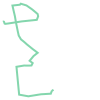

In [495]:
LineString(np.array(backtracked_trace)[:, [1,0]])
# first 1381

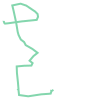

In [474]:
LineString(trip_df[['long', 'lat']].values)
# 19500

/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/lib/python3.7/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


CPU times: user 7.28 s, sys: 200 ms, total: 7.48 s
Wall time: 7.81 s


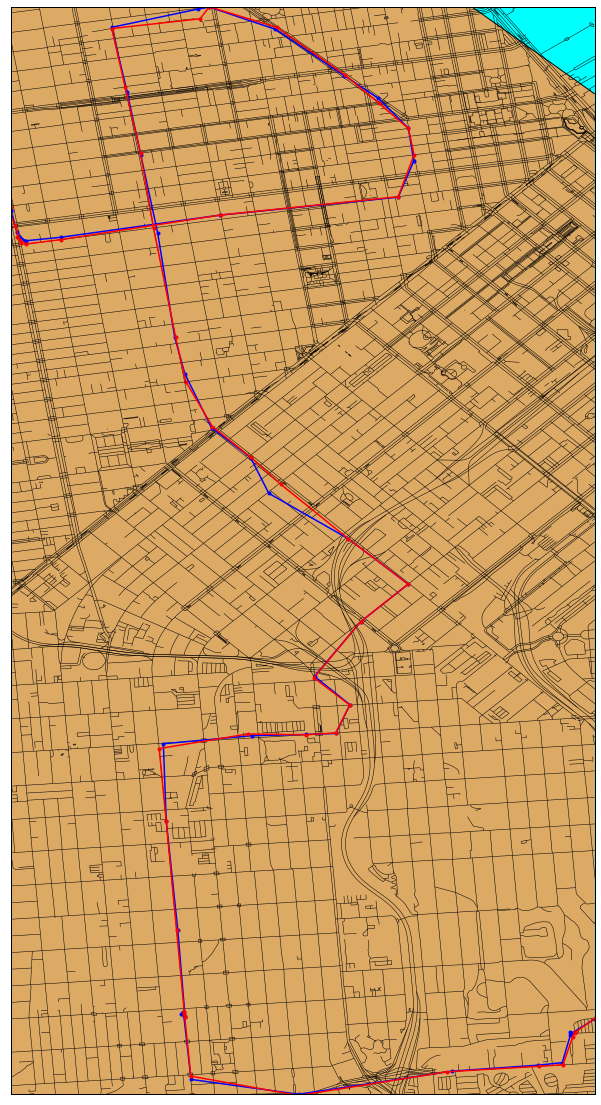

In [497]:
%%time

trace_bounds = LineString(trip_df[['long', 'lat']].values).bounds

fig = plt.figure(figsize=(20, 20))

map = Basemap(llcrnrlon=trace_bounds[0], llcrnrlat=trace_bounds[1], 
              urcrnrlon=trace_bounds[2], urcrnrlat=trace_bounds[3],
              resolution='i'
#               , projection='tmerc'
             )

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='#ddaa66', lake_color='aqua')
map.drawcoastlines()

# map.readshapefile(basemap_dir[:-4], 'roads')

roads_info = map.readshapefile(basemap_dir[:-4], 'roads')

# print(roads_info)

# plot the full trace
map.plot(trip_df.long.values, trip_df.lat.values, marker=".", color='blue')

# overlay the backtracked trace
map.plot(np.array(backtracked_trace)[:, [1]], np.array(backtracked_trace)[:, [0]], marker=".", color='red')

plt.savefig("_".join((all_files[1][:-4], str(trip_idx))) + ".png")

# Seeing some corrections, but it doesn't fill in the gaps between missing measurements, 
# where we still see bird-flight paths from a line view. - I'm only plotting the nearest real road to observed points
# This algorithm is not meant to fill in gaps between measurements...

In [ ]:
#  IGNORE BELOW THIS POINT

In [ ]:
# https://stackoverflow.com/questions/4102520/how-to-transform-a-distance-from-degrees-to-metres
"""
@winwaed
The transformation between degrees and metres varies across the Earth's surface.
Assuming a spherical Earth, degrees latitude = distance * 360 / (2*PI * 6400000)
Note that longitude will vary according to the latitude:
Degrees longitude = distance *360 * / (2*PI* cos(latitude) )

The above is for the Earth's surface, and does not use the Mercator projection. 
If you wish to work with projected linear distance, then you will need to use the Mercator projection.
"""
# RADIUS_OF_EARTH_M = 6371000
# long, lat = list(obs.coords)[0]
# max_dist_deg = max_dist * 360 / (2 * np.pi * RADIUS_OF_EARTH_M)